In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 23.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 21.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/stanford/lbp/hellinger_stanford_lbp_above.csv")
train_df2 = pd.read_csv("files/stanford/lbp/hellinger_stanford_lbp_below.csv")

In [5]:
print(train_df2)

                                              file                       label
0      n02108915-French_bulldog/n02108915_3880.jpg    n02108915-French_bulldog
1       n02108915-French_bulldog/n02108915_341.jpg    n02108915-French_bulldog
2      n02108915-French_bulldog/n02108915_2391.jpg    n02108915-French_bulldog
3     n02108915-French_bulldog/n02108915_11550.jpg    n02108915-French_bulldog
4      n02108915-French_bulldog/n02108915_2681.jpg    n02108915-French_bulldog
..                                             ...                         ...
824  n02113712-miniature_poodle/n02113712_3293.jpg  n02113712-miniature_poodle
825  n02113712-miniature_poodle/n02113712_3315.jpg  n02113712-miniature_poodle
826  n02113712-miniature_poodle/n02113712_9013.jpg  n02113712-miniature_poodle
827  n02113712-miniature_poodle/n02113712_1805.jpg  n02113712-miniature_poodle
828  n02113712-miniature_poodle/n02113712_3049.jpg  n02113712-miniature_poodle

[829 rows x 2 columns]


In [6]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [7]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="StanfordDogs/Stanford_Dogs/Images",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="StanfordDogs/Stanford_Dogs/Images/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")



Found 592 non-validated image filenames belonging to 10 classes.
Found 664 non-validated image filenames belonging to 10 classes.


In [8]:
model_name = vgg16
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)


In [9]:
model_t.trainable = False
model_t2.trainable = False

In [10]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [11]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(10, activation='softmax'))




In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [13]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=150, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=150, verbose=1)



Epoch 1/150
74/74 [==============================] - 25s 291ms/step - loss: 2.8427 - accuracy: 0.1666 - precision: 0.1871 - recall: 0.0477
Epoch 2/150
74/74 [==============================] - 10s 136ms/step - loss: 2.0210 - accuracy: 0.3379 - precision: 0.5175 - recall: 0.1794
Epoch 3/150
74/74 [==============================] - 10s 137ms/step - loss: 1.8196 - accuracy: 0.3870 - precision: 0.5275 - recall: 0.2133
Epoch 4/150
74/74 [==============================] - 10s 135ms/step - loss: 1.7987 - accuracy: 0.3936 - precision: 0.5954 - recall: 0.2184
Epoch 5/150
74/74 [==============================] - 10s 136ms/step - loss: 1.7955 - accuracy: 0.3773 - precision: 0.5160 - recall: 0.1937
Epoch 6/150
74/74 [==============================] - 10s 133ms/step - loss: 1.6403 - accuracy: 0.4462 - precision: 0.5796 - recall: 0.2333
Epoch 7/150
74/74 [==============================] - 10s 139ms/step - loss: 1.6327 - accuracy: 0.4238 - precision: 0.5508 - recall: 0.2110
Epoch 8/150
74/74 [========

74/74 [==============================] - 10s 137ms/step - loss: 1.0083 - accuracy: 0.6925 - precision: 0.8539 - recall: 0.4720
Epoch 60/150
74/74 [==============================] - 10s 137ms/step - loss: 0.9126 - accuracy: 0.7170 - precision: 0.8933 - recall: 0.4842
Epoch 61/150
74/74 [==============================] - 10s 138ms/step - loss: 0.9283 - accuracy: 0.7174 - precision: 0.8738 - recall: 0.5113
Epoch 62/150
74/74 [==============================] - 10s 133ms/step - loss: 0.9653 - accuracy: 0.7033 - precision: 0.8822 - recall: 0.4932
Epoch 63/150
74/74 [==============================] - 10s 138ms/step - loss: 0.9980 - accuracy: 0.6837 - precision: 0.8306 - recall: 0.4746
Epoch 64/150
74/74 [==============================] - 10s 132ms/step - loss: 1.0354 - accuracy: 0.6656 - precision: 0.8321 - recall: 0.4513
Epoch 65/150
74/74 [==============================] - 10s 136ms/step - loss: 1.0356 - accuracy: 0.6796 - precision: 0.8209 - recall: 0.4490
Epoch 66/150
74/74 [=============

74/74 [==============================] - 10s 135ms/step - loss: 0.7721 - accuracy: 0.7518 - precision: 0.9284 - recall: 0.5811
Epoch 118/150
74/74 [==============================] - 10s 130ms/step - loss: 0.7446 - accuracy: 0.7640 - precision: 0.8506 - recall: 0.5836
Epoch 119/150
74/74 [==============================] - 10s 138ms/step - loss: 0.8717 - accuracy: 0.7267 - precision: 0.8680 - recall: 0.5478
Epoch 120/150
74/74 [==============================] - 10s 132ms/step - loss: 0.8064 - accuracy: 0.7288 - precision: 0.8611 - recall: 0.5562
Epoch 121/150
74/74 [==============================] - 10s 136ms/step - loss: 0.7634 - accuracy: 0.7900 - precision: 0.8901 - recall: 0.5633
Epoch 122/150
74/74 [==============================] - 10s 134ms/step - loss: 0.7300 - accuracy: 0.7945 - precision: 0.9107 - recall: 0.5927
Epoch 123/150
74/74 [==============================] - 10s 137ms/step - loss: 0.8240 - accuracy: 0.7331 - precision: 0.8850 - recall: 0.5634
Epoch 124/150
74/74 [======

83/83 [==============================] - 11s 138ms/step - loss: 1.0510 - accuracy: 0.6220 - precision: 0.7846 - recall: 0.4431
Epoch 26/150
83/83 [==============================] - 12s 144ms/step - loss: 1.1044 - accuracy: 0.6406 - precision: 0.7926 - recall: 0.4578
Epoch 27/150
83/83 [==============================] - 11s 132ms/step - loss: 1.0722 - accuracy: 0.6663 - precision: 0.8303 - recall: 0.5027
Epoch 28/150
83/83 [==============================] - 12s 140ms/step - loss: 1.1068 - accuracy: 0.6338 - precision: 0.7448 - recall: 0.4529
Epoch 29/150
83/83 [==============================] - 11s 135ms/step - loss: 1.1088 - accuracy: 0.6270 - precision: 0.7518 - recall: 0.4377
Epoch 30/150
83/83 [==============================] - 11s 134ms/step - loss: 1.0445 - accuracy: 0.6667 - precision: 0.8097 - recall: 0.4729
Epoch 31/150
83/83 [==============================] - 11s 135ms/step - loss: 1.0285 - accuracy: 0.6616 - precision: 0.7800 - recall: 0.4534
Epoch 32/150
83/83 [=============

83/83 [==============================] - 11s 135ms/step - loss: 0.8820 - accuracy: 0.7096 - precision: 0.8101 - recall: 0.5417
Epoch 84/150
83/83 [==============================] - 11s 131ms/step - loss: 0.8604 - accuracy: 0.7395 - precision: 0.8543 - recall: 0.5668
Epoch 85/150
83/83 [==============================] - 12s 138ms/step - loss: 0.8039 - accuracy: 0.7506 - precision: 0.8628 - recall: 0.5693
Epoch 86/150
83/83 [==============================] - 11s 136ms/step - loss: 0.7570 - accuracy: 0.7728 - precision: 0.8802 - recall: 0.6282
Epoch 87/150
83/83 [==============================] - 11s 135ms/step - loss: 0.7748 - accuracy: 0.7446 - precision: 0.8851 - recall: 0.5800
Epoch 88/150
83/83 [==============================] - 11s 136ms/step - loss: 0.8449 - accuracy: 0.7337 - precision: 0.8676 - recall: 0.5517
Epoch 89/150
83/83 [==============================] - 11s 133ms/step - loss: 0.8046 - accuracy: 0.7245 - precision: 0.8589 - recall: 0.5946
Epoch 90/150
83/83 [=============

83/83 [==============================] - 11s 131ms/step - loss: 0.7719 - accuracy: 0.7500 - precision: 0.8755 - recall: 0.5965
Epoch 142/150
83/83 [==============================] - 11s 134ms/step - loss: 0.8286 - accuracy: 0.7155 - precision: 0.8817 - recall: 0.5469
Epoch 143/150
83/83 [==============================] - 11s 137ms/step - loss: 0.8291 - accuracy: 0.7359 - precision: 0.8409 - recall: 0.5314
Epoch 144/150
83/83 [==============================] - 11s 133ms/step - loss: 0.8370 - accuracy: 0.7225 - precision: 0.8696 - recall: 0.5375
Epoch 145/150
83/83 [==============================] - 11s 131ms/step - loss: 0.7427 - accuracy: 0.8090 - precision: 0.8939 - recall: 0.6119
Epoch 146/150
83/83 [==============================] - 11s 135ms/step - loss: 0.8442 - accuracy: 0.7318 - precision: 0.8597 - recall: 0.5810
Epoch 147/150
83/83 [==============================] - 11s 136ms/step - loss: 0.7459 - accuracy: 0.7549 - precision: 0.9100 - recall: 0.5804
Epoch 148/150
83/83 [======

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


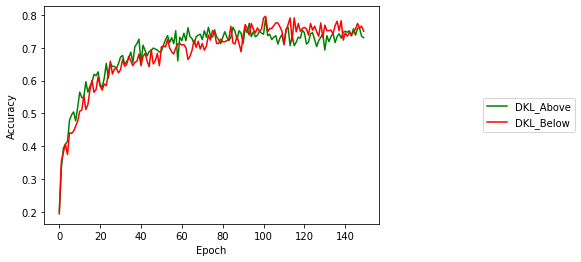

In [18]:
fig1 = plt.figure()

plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_hellinger_accuracy_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


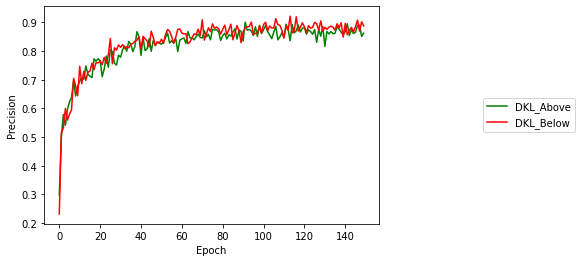

In [19]:
fig1 = plt.figure()



plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_hellinger_precision_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


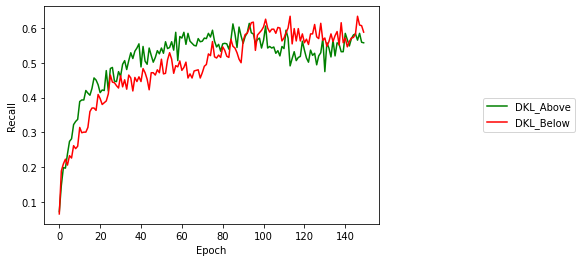

In [20]:
fig1 = plt.figure()

plt.plot(history2.history['recall'], color='g')
plt.plot(history.history['recall'], color='r')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_hellinger_recall_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 
